In [62]:
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pycountry_convert as pc
import unicodedata
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [72]:
df = pd.read_csv("/content/gdrive/MyDrive/DaVi/netflix.csv")

In [73]:
x_pca =pd.read_parquet("/content/gdrive/MyDrive/DaVi/x_pca4907.parquet")

# **TIỀN XỬ LÝ DỮ LIỆU**

In [74]:
df[['director','cast','country']] = df[['director','cast','country']].fillna('Unknown')
df.dropna(axis=0, inplace = True)

In [75]:
def get_content_type(rating):
    if rating in ['TV-MA', 'R', 'NC-17']:
        return 'Adult'
    elif rating in ['TV-14', 'PG-13']:
        return 'Teen'
    elif rating in ['TV-PG', 'TV-Y', 'TV-Y7', 'TV-Y7-FV', 'G', 'PG', 'TV-G']:
        return 'Family'
    else:
        return 'Unknown'

In [76]:
df['content_type'] = df['rating'].apply(get_content_type)

In [77]:
def get_continent(country):
    continents = set({})

    for country_name in country.split(','):
        country_name = country_name.strip()

        if country_name == 'Unknown':
            continents.add(country_name)
        elif len(country_name) <= 3:
            continents.add('Unknown')
        else:
            try:
                country_alpha2 = pc.country_name_to_country_alpha2(country_name)
                country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
                country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
                continents.add(country_continent_name)
            except KeyError:
                continents.add('Defunct Country') # Nếu tên quốc gia đã không còn
                continue

    return ', '.join(continents)

In [78]:
df['region'] = df['country'].apply(get_continent)

In [79]:
df1 = df.copy()
df1.fillna('',inplace=True)

In [80]:
df1['clustering_attributes'] = (df1['content_type'] + ' ' +
                                df1['country'] + ' ' +
                                df1['region'] + ' ' +
                                df1['listed_in'] +' ' +
                                df1['description'])

In [81]:
df1['clustering_attributes'][40]

"Family United States North America Kids' TV, TV Sci-Fi & Fantasy Mighty teen Adam and his heroic squad of misfits discover the legendary power of Grayskull — and their destiny to defend Eternia from sinister Skeletor."

**CLEAN TEXT**

In [82]:
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    words = text.lower().split()
    words = [word.lower().translate(str.maketrans('', '', string.punctuation)) for word in words]
    words = [word for word in words if word not in stop_words]
    processed_text = ' '.join(words)
    return processed_text
df1['clustering_attributes'] = df1['clustering_attributes'].apply(clean_text)

**REMOVE NON ASCII**

In [83]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [84]:
df1['clustering_attributes'] = remove_non_ascii(df1['clustering_attributes'])

**LEMMATIZE**

In [85]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [86]:
df1['clustering_attributes'] = lemmatize_verbs(df1['clustering_attributes'])

**TOKENIZE**

In [87]:
tokenizer = TweetTokenizer()

In [88]:
df1['clustering_attributes'] = df1['clustering_attributes'].apply(lambda x: tokenizer.tokenize(x))

In [89]:
clustering_data = df1['clustering_attributes']

# **TF-IDF**

In [90]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)
X = tfidf.fit_transform(clustering_data)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


In [91]:
X.shape

(8790, 20639)

In [92]:
X = X.toarray()

# **PCA**

In [ ]:
threshold = .9
percent   = threshold * 100

pca = PCA(threshold)
pca.fit_transform(X)

k   = pca.n_components_
var = sum(pca.explained_variance_ratio_) * 100
print('Phương sai tích lũy >= %.1f%%' %percent, 'khi k >= %d' %k)

Phương sai tích lũy >= 90.0% khi k >= 4907


In [ ]:
pca = PCA(n_components=k,random_state=42)
pca.fit(X)

In [ ]:
x_pca = pca.transform(X)
x_pca.shape

# **KMEANS**

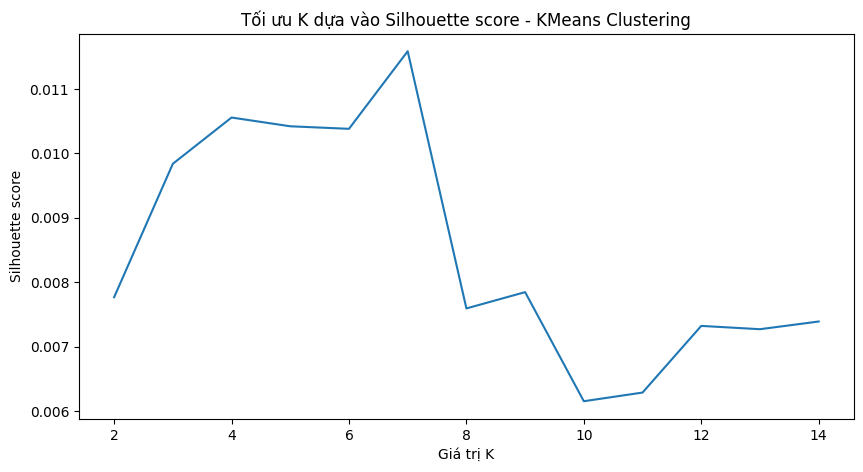

In [23]:
range_n_clusters = range(2,15)
silhouette_avg = []
for num_clusters in range_n_clusters:
  kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  cluster_labels = kmeans.labels_
  silhouette_avg.append(silhouette_score(x_pca, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Giá trị K')
plt.ylabel('Silhouette score')
plt.title('Tối ưu K dựa vào Silhouette score - KMeans Clustering')
plt.show()

In [93]:
kmeans = KMeans(n_clusters=7,init='k-means++',random_state=42)
kmeans.fit(x_pca)
kmeans_silhouette_score = silhouette_score(x_pca, kmeans.labels_)
print("Silhoutte score: ", kmeans_silhouette_score)
df1['kmeans_cluster'] = kmeans.labels_

Silhoutte score:  0.01142015737680232


# **PHÂN TÍCH OUTPUT SAU PHÂN CỤM**

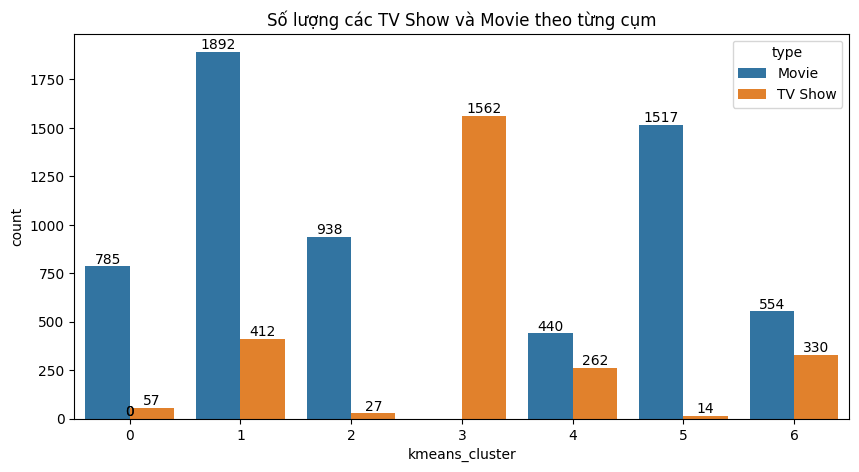

In [27]:
plt.figure(figsize=(10,5))
q = sns.countplot(x='kmeans_cluster',data=df1, hue='type')
plt.title('Số lượng các TV Show và Movie theo từng cụm')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()),
             ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [94]:
def split_columns(df, columns_to_split):
    new_rows = []

    for _, row in df.iterrows():
        split_values = {col: row[col].split(', ') if pd.notna(row[col]) else ['Unknown']
                        for col in columns_to_split}

        from itertools import product
        combinations = list(product(*split_values.values()))

        for combination in combinations:
            new_row = row.copy()
            for i, col in enumerate(columns_to_split):
                new_row[col] = combination[i]
            new_rows.append(new_row)

    df_new = pd.DataFrame(new_rows, columns=df.columns)
    return df_new

columns_to_split = ['country', 'listed_in']
expanded_df = split_columns(df1, columns_to_split)
expanded_df['region'] = expanded_df['country'].apply(get_continent)


In [95]:
expanded_df['description'] = df1['description']

In [96]:
expanded_df

show_id     type                 title         director  \
0         s1    Movie  Dick Johnson Is Dead  Kirsten Johnson   
1         s2  TV Show         Blood & Water          Unknown   
1         s2  TV Show         Blood & Water          Unknown   
1         s2  TV Show         Blood & Water          Unknown   
2         s3  TV Show             Ganglands  Julien Leclercq   
...      ...      ...                   ...              ...   
8805   s8806    Movie                  Zoom     Peter Hewitt   
8805   s8806    Movie                  Zoom     Peter Hewitt   
8806   s8807    Movie                Zubaan      Mozez Singh   
8806   s8807    Movie                Zubaan      Mozez Singh   
8806   s8807    Movie                Zubaan      Mozez Singh   

                                                   cast        country  \
0                                               Unknown  United States   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2     Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        Unknown   
...                                                 ...            ...   
8805  Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...  United States   
8805  Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...  United States   
8806  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...          India   
8806  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...          India   
8806  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...          India   

              date_added  release_year rating   duration  \
0     September 25, 2021          2020  PG-13     90 min   
1     September 24, 2021          2021  TV-MA  2 Seasons   
1     September 24, 2021          2021  TV-MA  2 Seasons   
1     September 24, 2021          2021  TV-MA  2 Seasons   
2     September 24, 2021          2021  TV-MA   1 Season   
...                  ...           ...    ...        ...   
8805    January 11, 2020          2006     PG     88 min   
8805    January 11, 2020          2006     PG     88 min   
8806       March 2, 2019          2015  TV-14    111 min   
8806       March 2, 2019          2015  TV-14    111 min   
8806       March 2, 2019          2015  TV-14    111 min   

                     listed_in  \
0                Documentaries   
1       International TV Shows   
1                    TV Dramas   
1                 TV Mysteries   
2               Crime TV Shows   
...                        ...   
8805  Children & Family Movies   
8805                  Comedies   
8806                    Dramas   
8806      International Movies   
8806          Music & Musicals   

                                            description content_type  \
0     As her father nears the end of his life, filmm...         Teen   
1     After crossing paths at a party, a Cape Town t...        Adult   
1     After crossing paths at a party, a Cape Town t...        Adult   
1     After crossing paths at a party, a Cape Town t...        Adult   
2     To protect his family from a powerful drug lor...        Adult   
...                                                 ...          ...   
8805  Dragged from civilian life, a former superhero...       Family   
8805  Dragged from civilian life, a former superhero...       Family   
8806  A scrappy but poor boy worms his way into a ty...         Teen   
8806  A scrappy but poor boy worms his way into a ty...         Teen   
8806  A scrappy but poor boy worms his way into a ty...         Teen   

             region                              clustering_attributes  \
0     North America  [teen, united, states, north, america, documen...   
1            Africa  [adult, south, africa, africa, international, ...   
1            Africa  [adult, south, africa, africa, international, ...   
1            Africa  [adult, south, africa, africa, inte

In [97]:
df = expanded_df.copy()

In [32]:
filtered_df = expanded_df[
    (expanded_df['kmeans_cluster'] == 1) &
    (expanded_df['country'] == 'United States') &
    (expanded_df['region'] != 'North America')
]

filtered_df

Empty DataFrame
Columns: [show_id, type, title, director, cast, country, date_added, release_year, rating, duration, listed_in, description, content_type, region, clustering_attributes, kmeans_cluster]
Index: []

# Số lượng phim của từng cụm

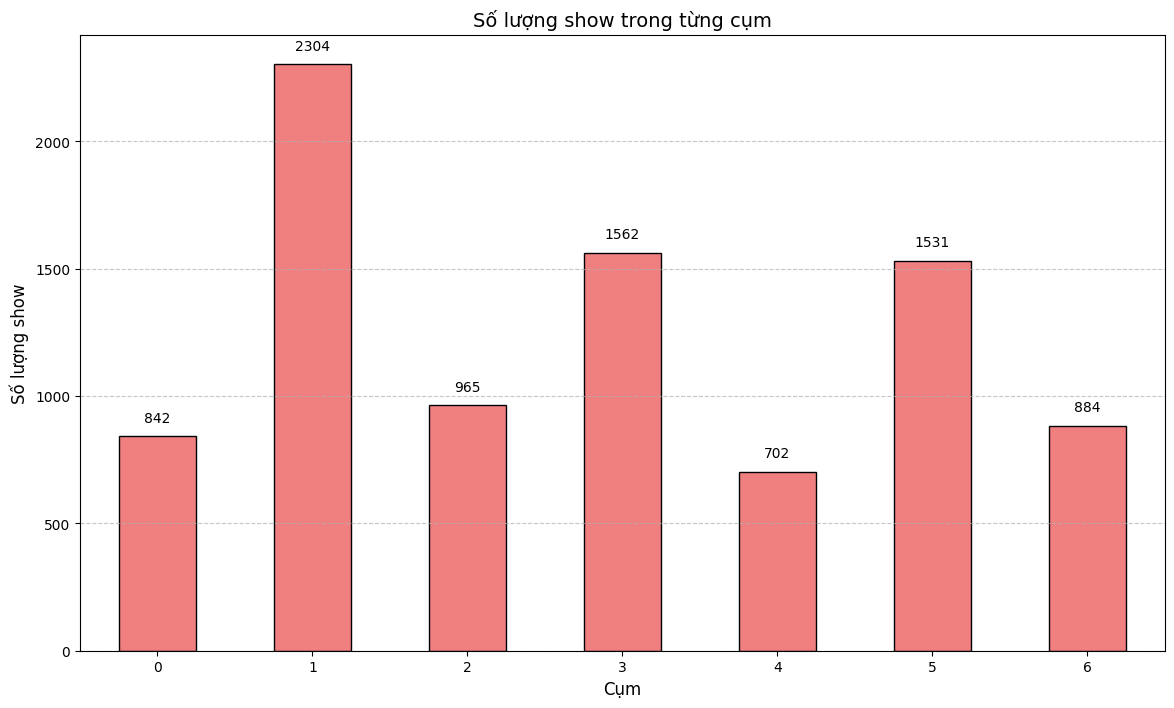

In [98]:
cluster_counts = df1.groupby("kmeans_cluster")["show_id"].nunique()

plt.figure(figsize=(14, 8))
ax = cluster_counts.sort_index().plot(kind="bar", color="lightcoral", edgecolor="black")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, 8),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.title("Số lượng show trong từng cụm", fontsize=14)
plt.xlabel("Cụm", fontsize=12)
plt.ylabel("Số lượng show", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Top 10 country có số lượng phim cao nhất trong từng cụm

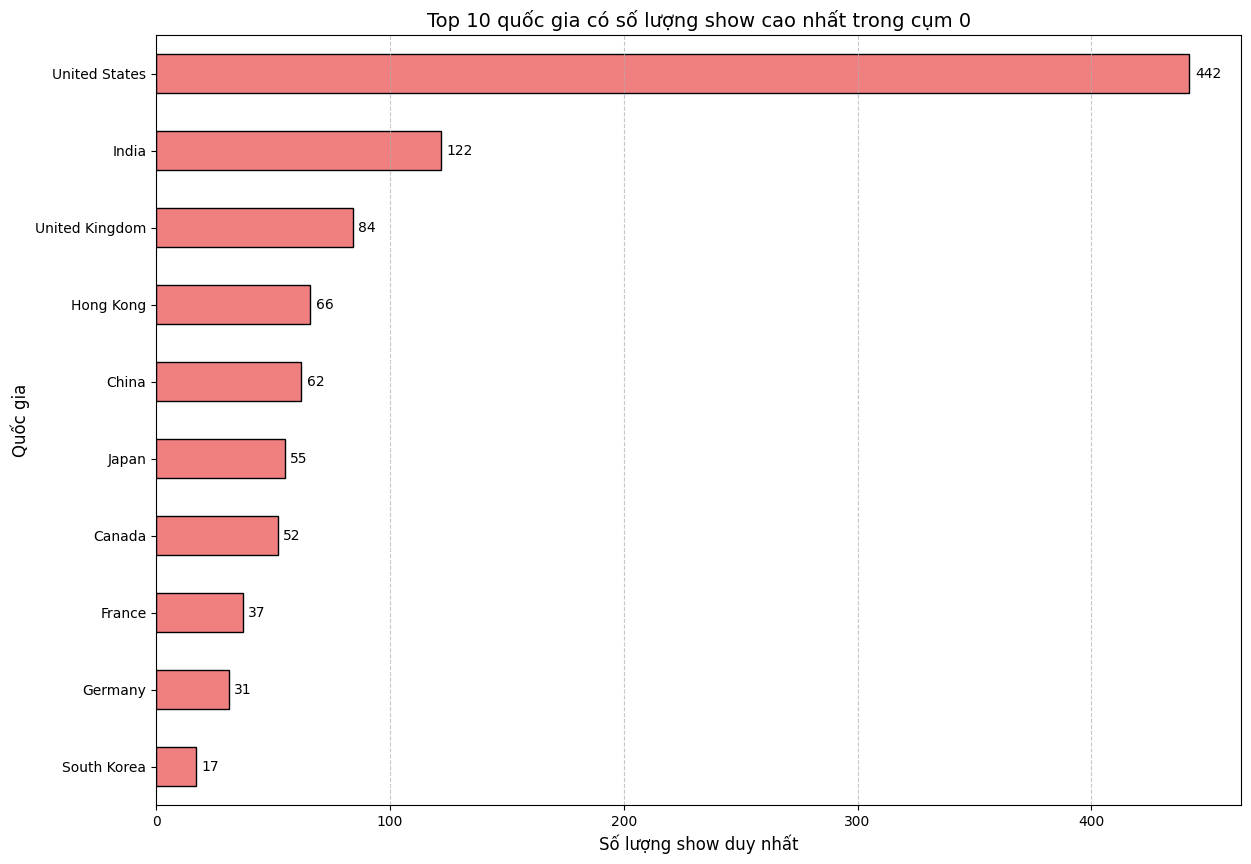

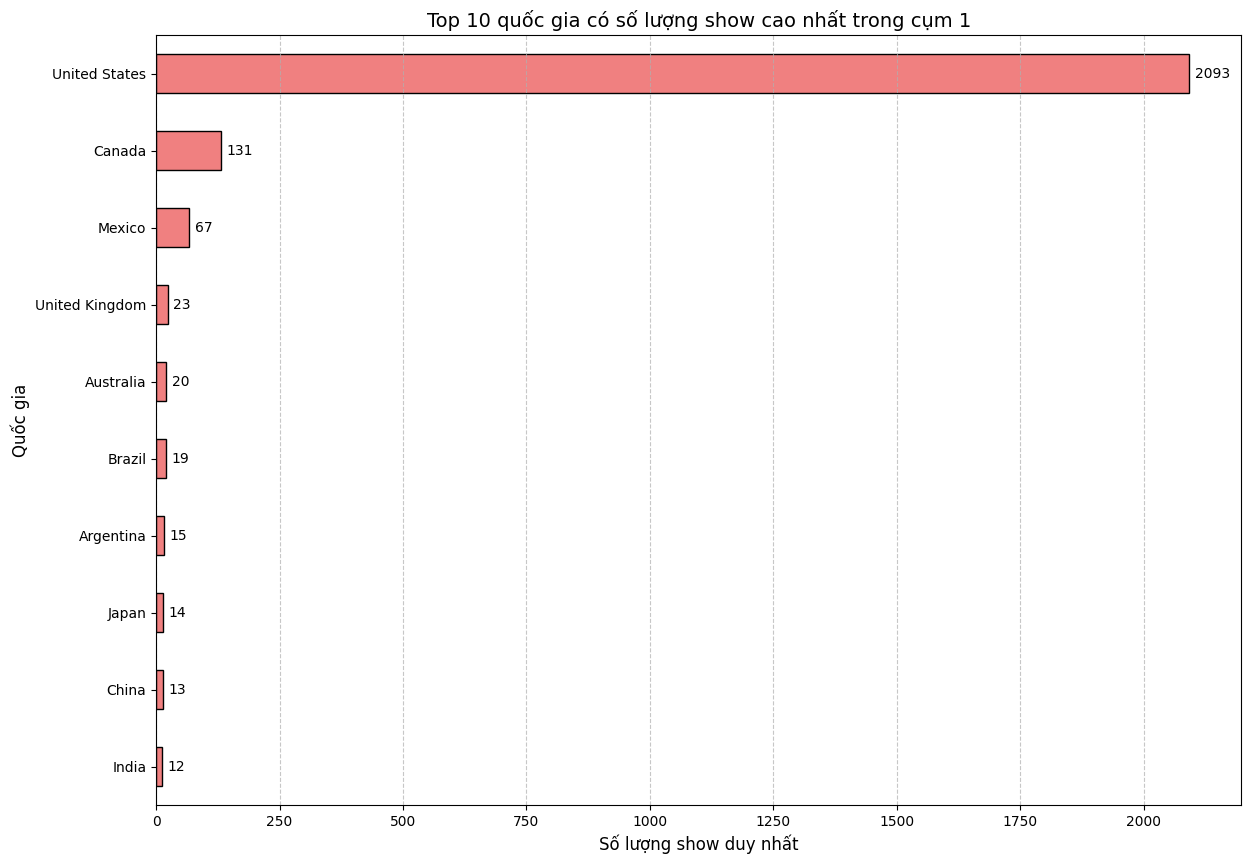

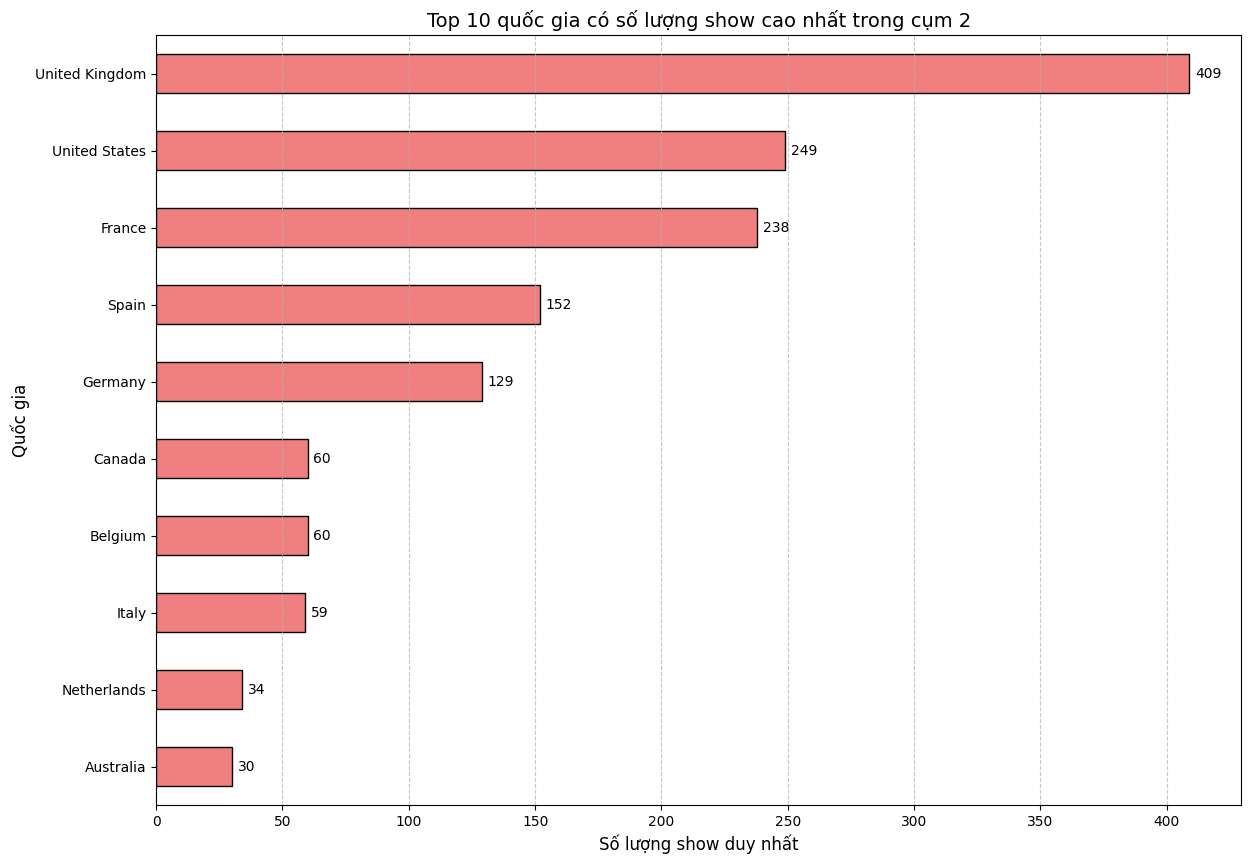

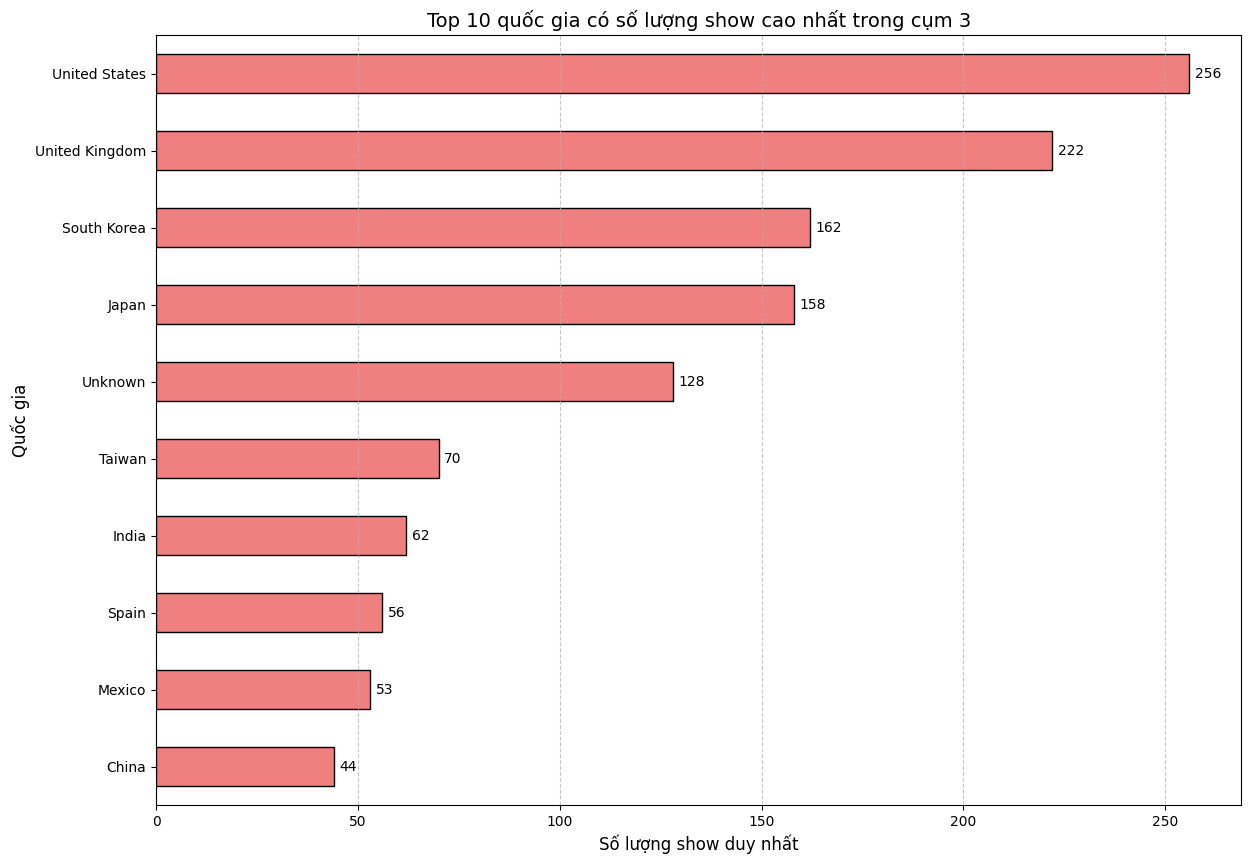

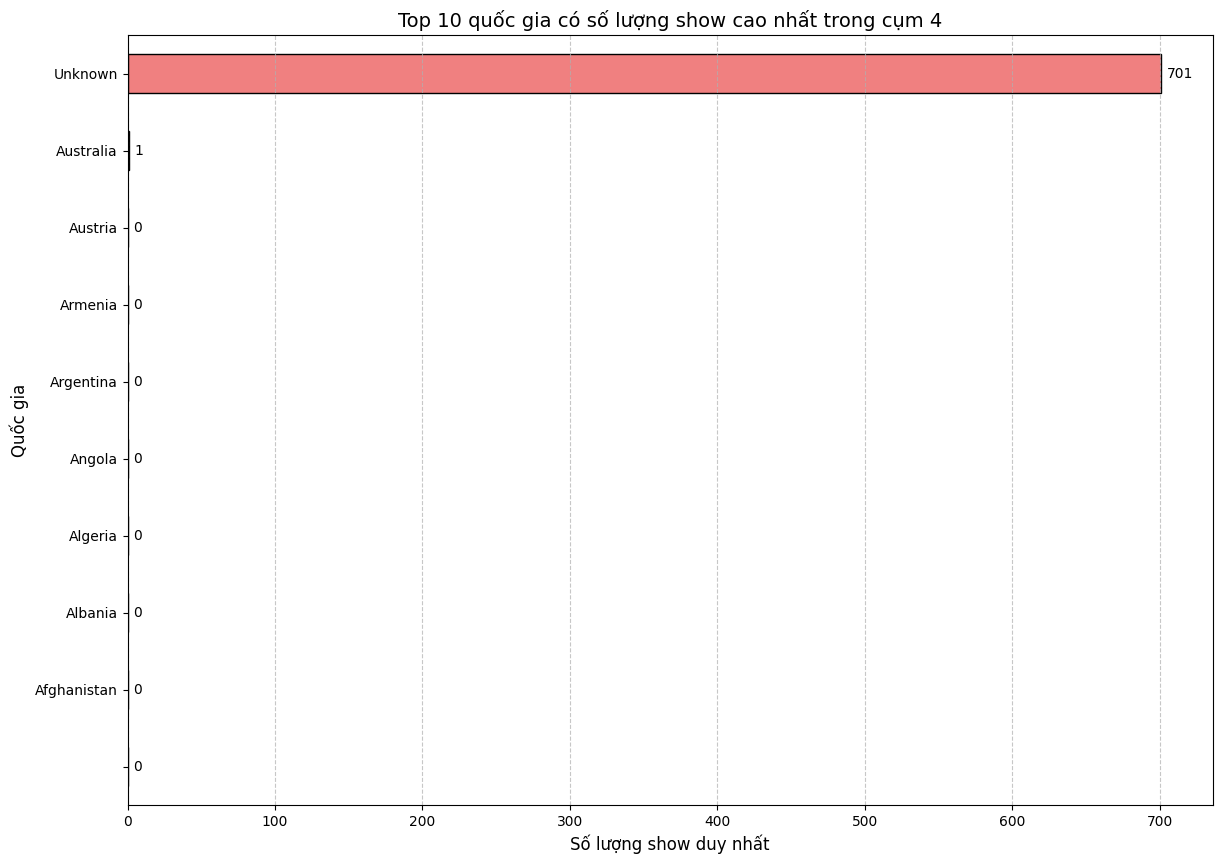

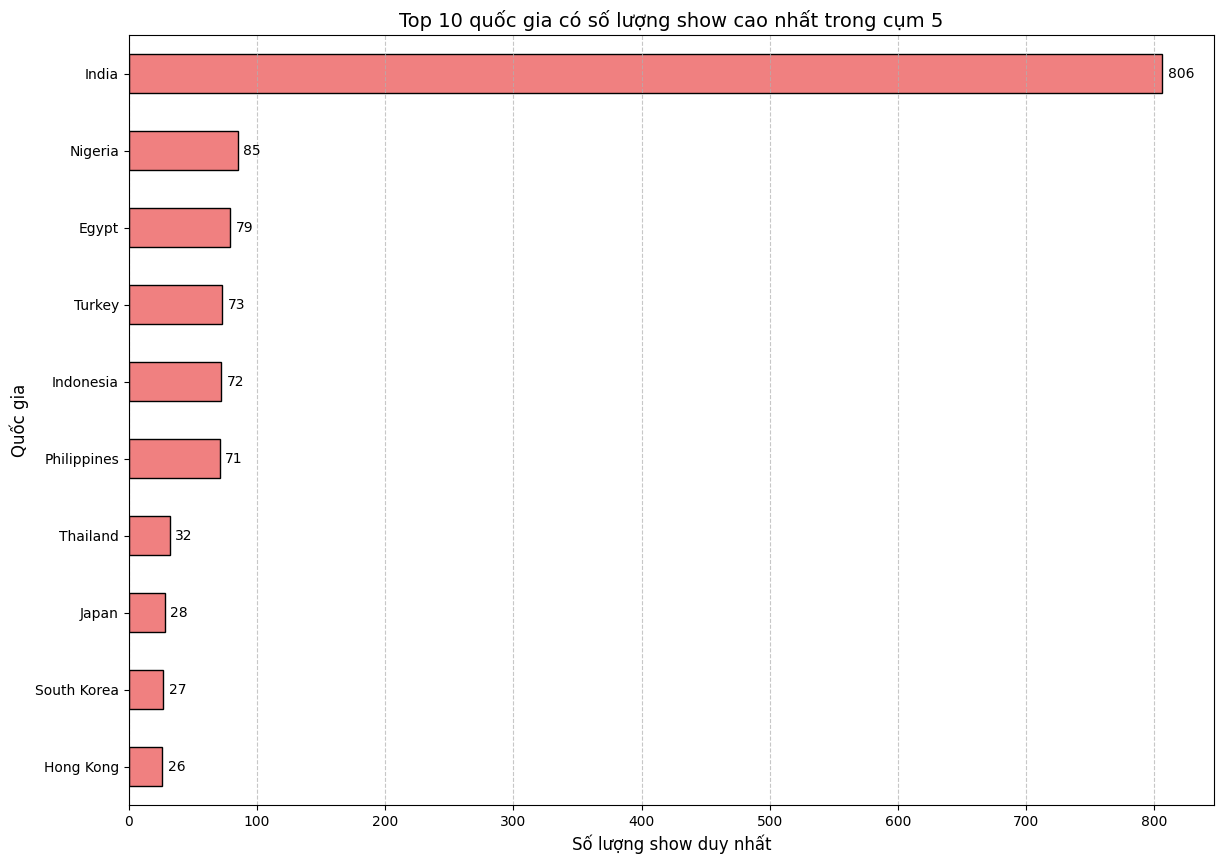

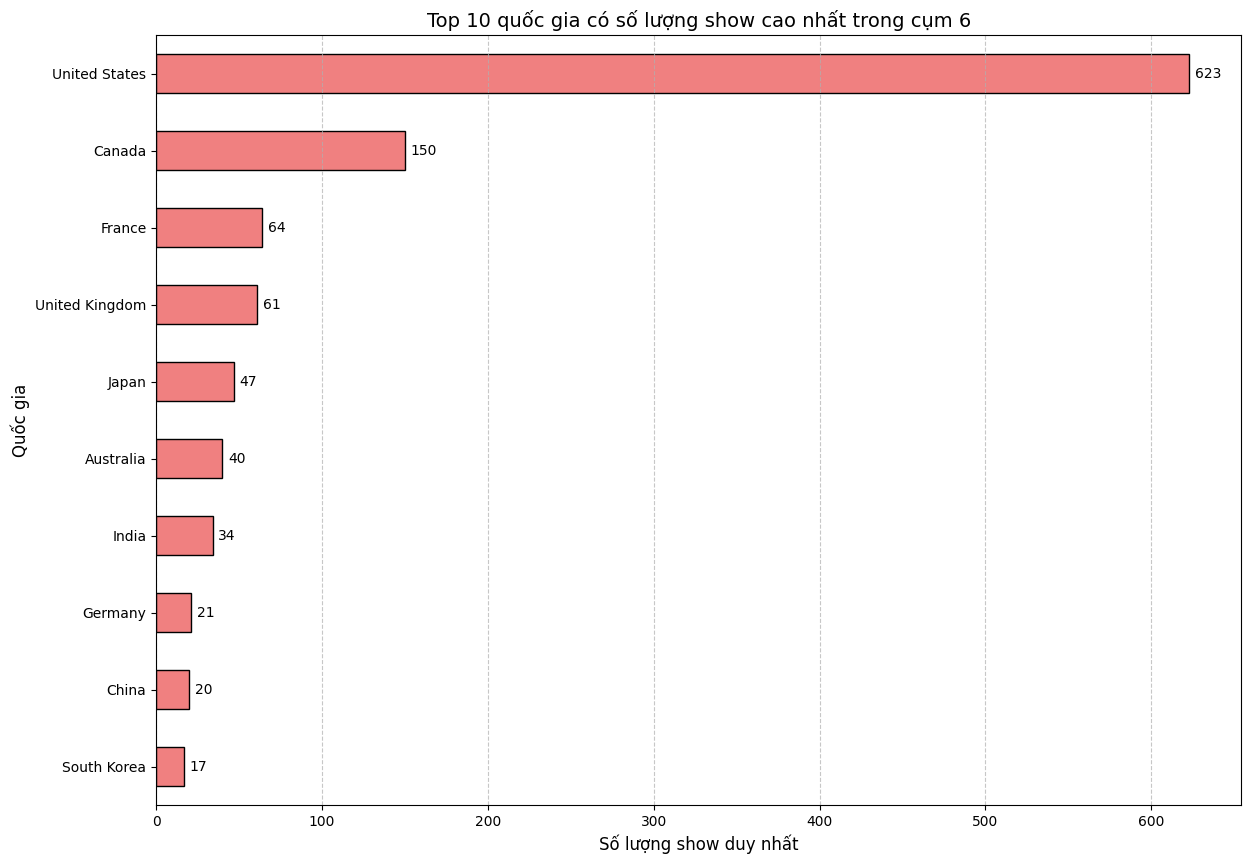

In [100]:
top_10_countries_per_cluster = df.groupby(["kmeans_cluster", "country"])["show_id"].nunique().unstack(fill_value=0)

for cluster in top_10_countries_per_cluster.index:
    top_10_countries_cluster = top_10_countries_per_cluster.loc[cluster].nlargest(10)

    plt.figure(figsize=(14, 10))
    ax = top_10_countries_cluster.sort_values().plot(kind="barh", color="lightcoral", edgecolor="black")

    for p in ax.patches:
        ax.annotate(f'{p.get_width()}',
                    (p.get_width(), p.get_y() + p.get_height() / 2.),
                    xytext=(4, 0),
                    textcoords="offset points",
                    ha='left', va='center', fontsize=10)

    plt.title(f"Top 10 quốc gia có số lượng show cao nhất trong cụm {cluster}", fontsize=14)
    plt.ylabel("Quốc gia", fontsize=12)
    plt.xlabel("Số lượng show duy nhất", fontsize=12)
    plt.yticks(rotation=0)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()
    print("\n\n\n")


# Top 10 region có số lượng phim cao nhất của từng cụm

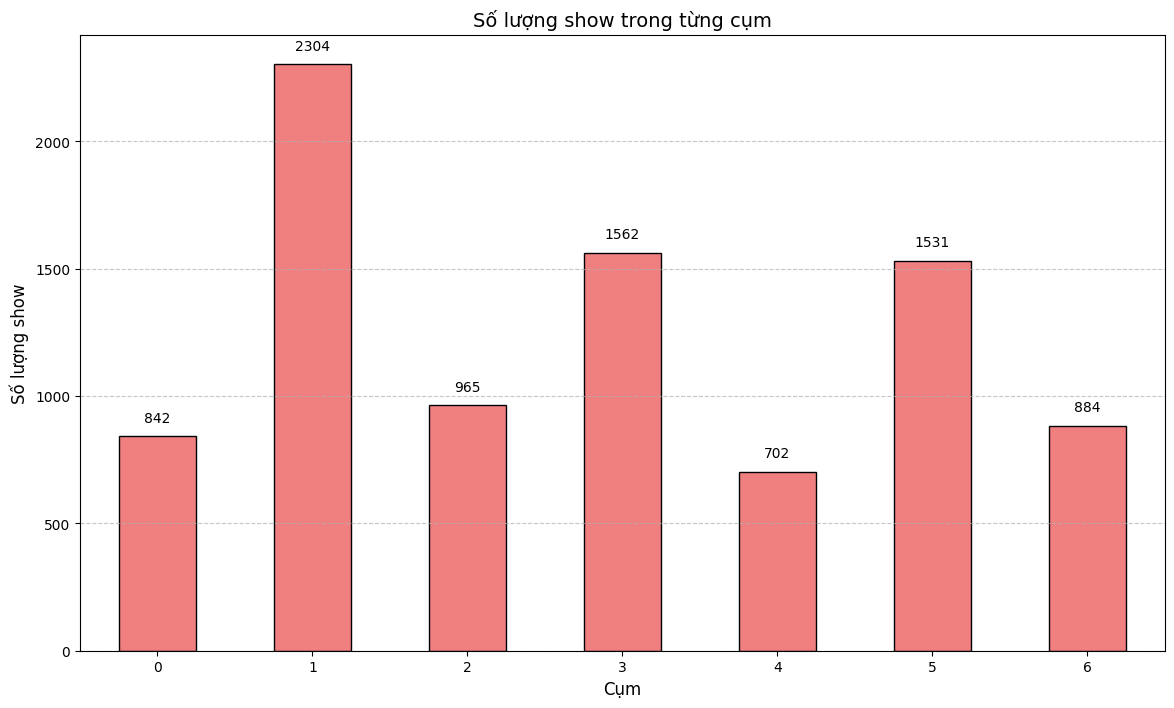

In [104]:
cluster_counts = df.groupby("kmeans_cluster")["show_id"].nunique()

plt.figure(figsize=(14, 8))
ax = cluster_counts.sort_index().plot(kind="bar", color="lightcoral", edgecolor="black")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, 8),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.title("Số lượng show trong từng cụm", fontsize=14)
plt.xlabel("Cụm", fontsize=12)
plt.ylabel("Số lượng show", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [106]:
expanded_df

show_id     type                 title         director  \
0         s1    Movie  Dick Johnson Is Dead  Kirsten Johnson   
1         s2  TV Show         Blood & Water          Unknown   
1         s2  TV Show         Blood & Water          Unknown   
1         s2  TV Show         Blood & Water          Unknown   
2         s3  TV Show             Ganglands  Julien Leclercq   
...      ...      ...                   ...              ...   
8805   s8806    Movie                  Zoom     Peter Hewitt   
8805   s8806    Movie                  Zoom     Peter Hewitt   
8806   s8807    Movie                Zubaan      Mozez Singh   
8806   s8807    Movie                Zubaan      Mozez Singh   
8806   s8807    Movie                Zubaan      Mozez Singh   

                                                   cast        country  \
0                                               Unknown  United States   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2     Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        Unknown   
...                                                 ...            ...   
8805  Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...  United States   
8805  Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...  United States   
8806  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...          India   
8806  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...          India   
8806  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...          India   

              date_added  release_year rating   duration  \
0     September 25, 2021          2020  PG-13     90 min   
1     September 24, 2021          2021  TV-MA  2 Seasons   
1     September 24, 2021          2021  TV-MA  2 Seasons   
1     September 24, 2021          2021  TV-MA  2 Seasons   
2     September 24, 2021          2021  TV-MA   1 Season   
...                  ...           ...    ...        ...   
8805    January 11, 2020          2006     PG     88 min   
8805    January 11, 2020          2006     PG     88 min   
8806       March 2, 2019          2015  TV-14    111 min   
8806       March 2, 2019          2015  TV-14    111 min   
8806       March 2, 2019          2015  TV-14    111 min   

                     listed_in  \
0                Documentaries   
1       International TV Shows   
1                    TV Dramas   
1                 TV Mysteries   
2               Crime TV Shows   
...                        ...   
8805  Children & Family Movies   
8805                  Comedies   
8806                    Dramas   
8806      International Movies   
8806          Music & Musicals   

                                            description content_type  \
0     As her father nears the end of his life, filmm...         Teen   
1     After crossing paths at a party, a Cape Town t...        Adult   
1     After crossing paths at a party, a Cape Town t...        Adult   
1     After crossing paths at a party, a Cape Town t...        Adult   
2     To protect his family from a powerful drug lor...        Adult   
...                                                 ...          ...   
8805  Dragged from civilian life, a former superhero...       Family   
8805  Dragged from civilian life, a former superhero...       Family   
8806  A scrappy but poor boy worms his way into a ty...         Teen   
8806  A scrappy but poor boy worms his way into a ty...         Teen   
8806  A scrappy but poor boy worms his way into a ty...         Teen   

             region                              clustering_attributes  \
0     North America  [teen, united, states, north, america, documen...   
1            Africa  [adult, south, africa, africa, international, ...   
1            Africa  [adult, south, africa, africa, international, ...   
1            Africa  [adult, south, africa, africa, inte

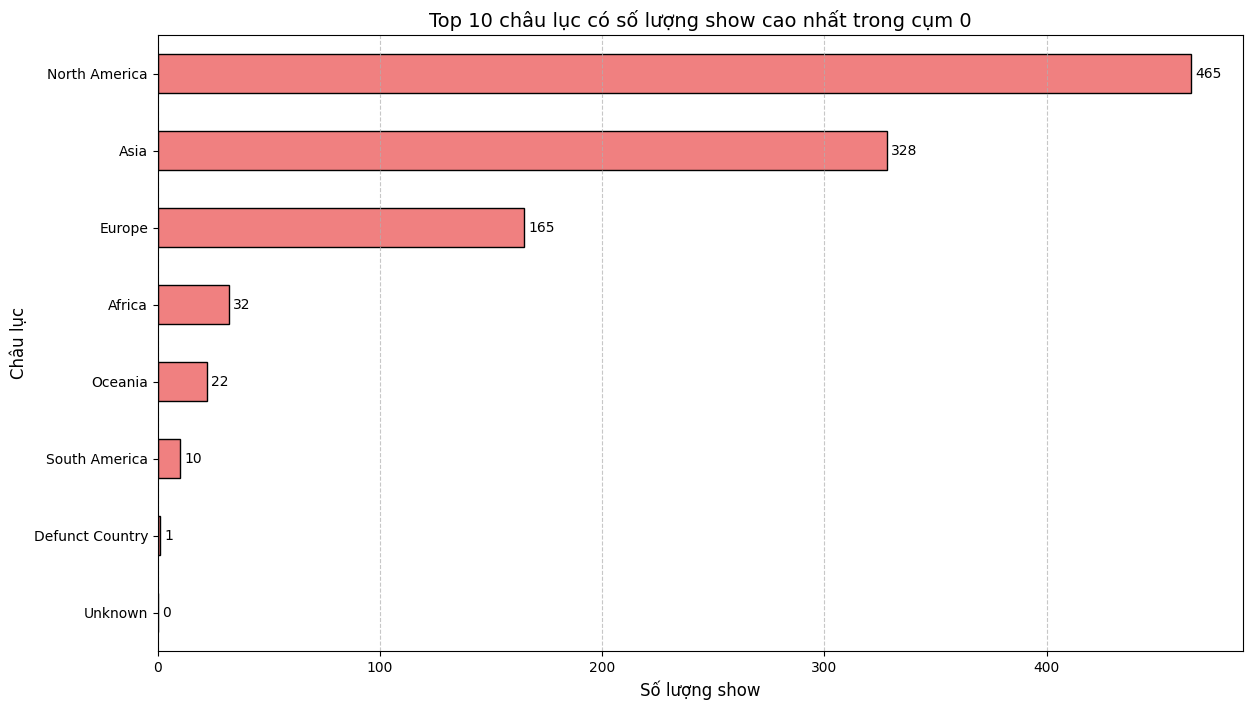

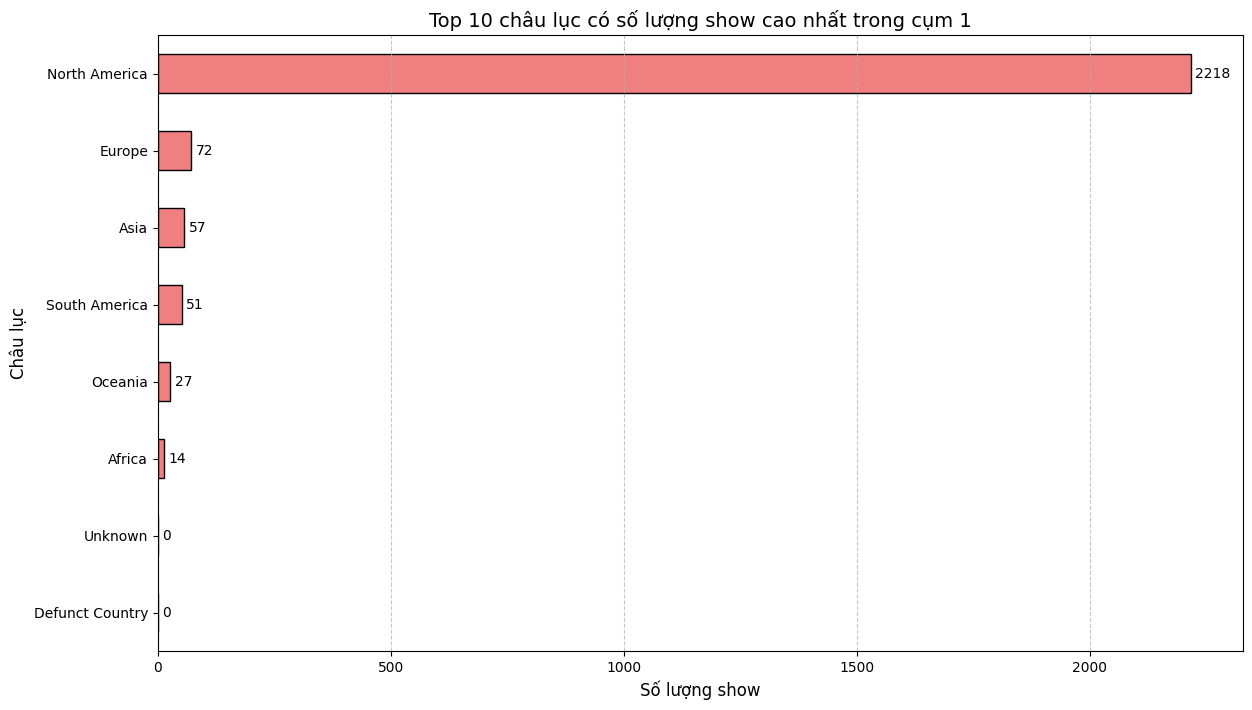

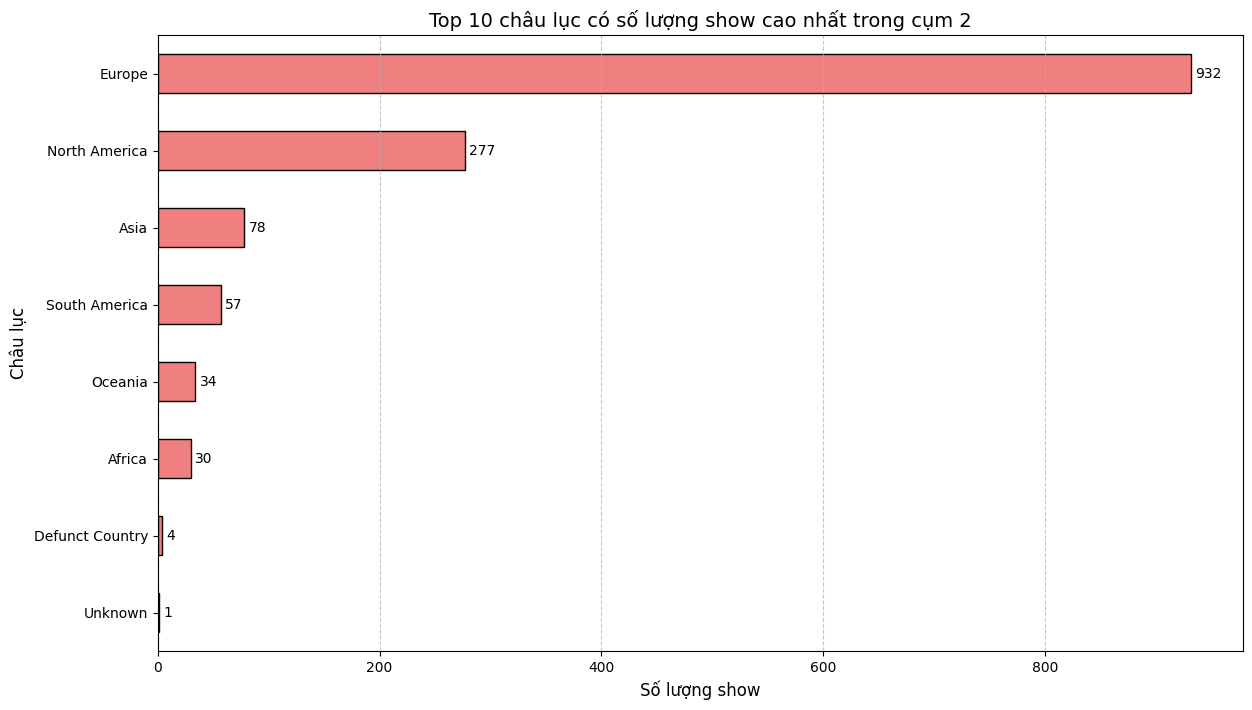

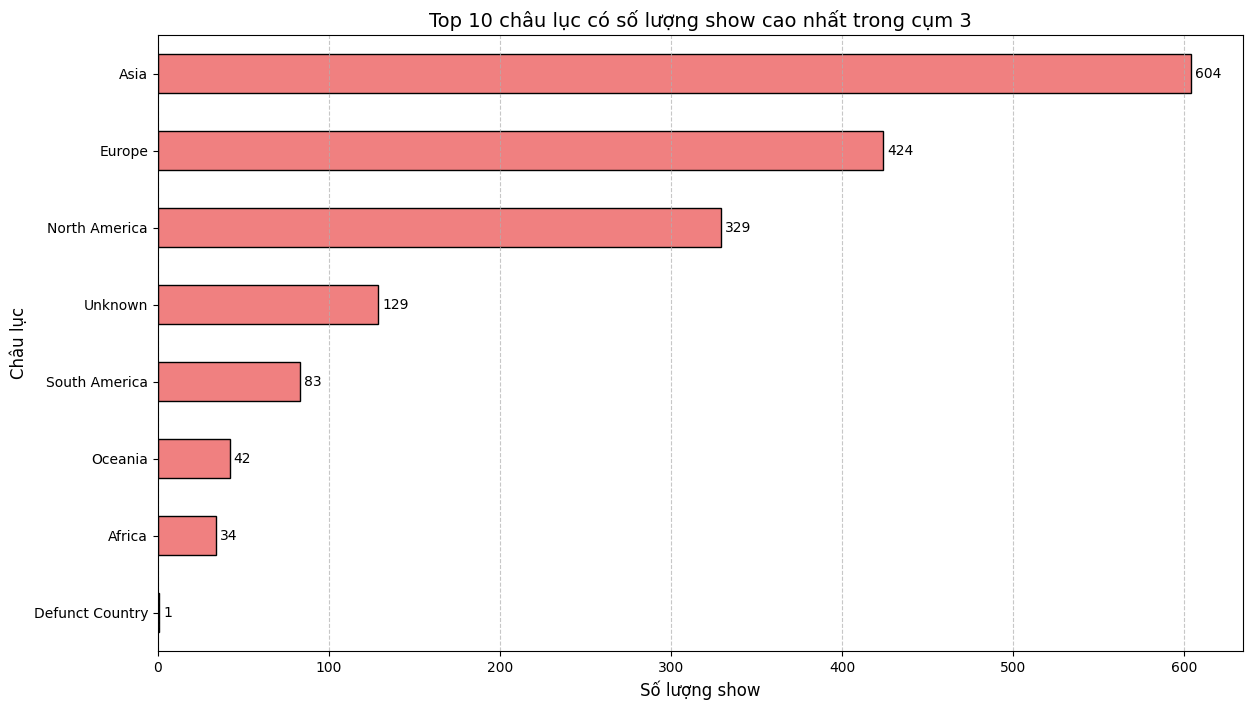

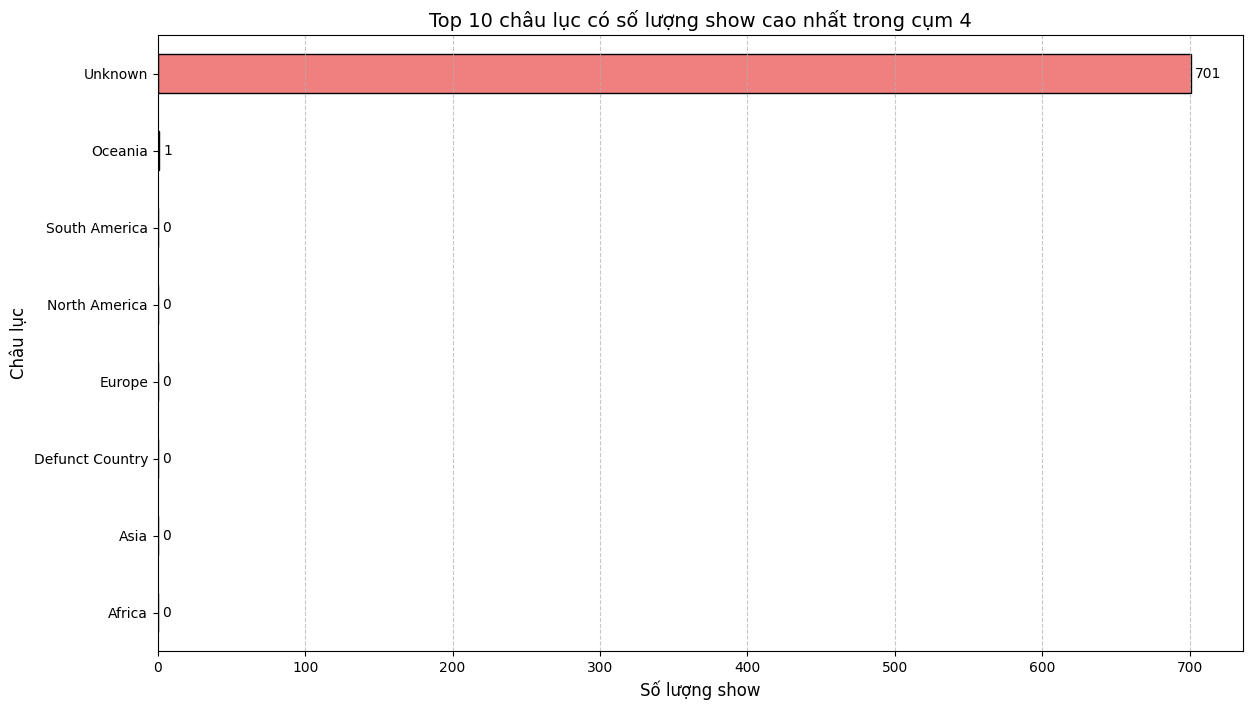

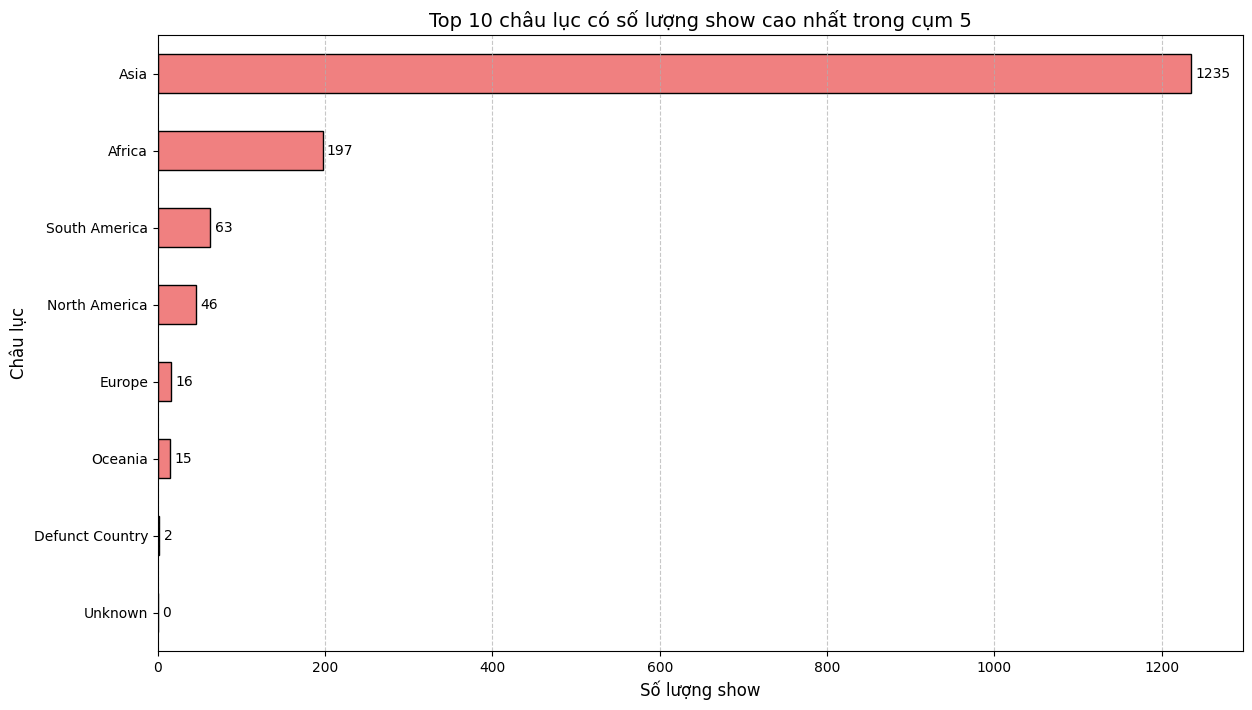

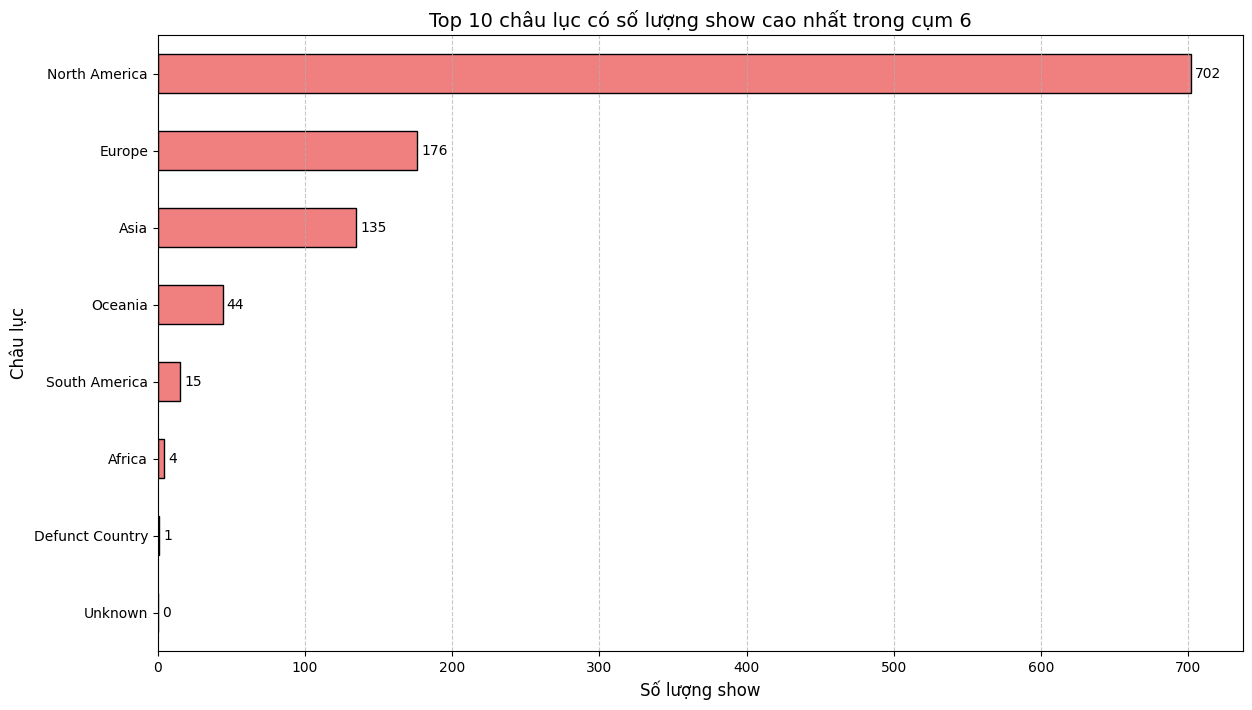

In [112]:
top_10_regions_per_cluster = df.groupby(["kmeans_cluster", "region"])["show_id"].nunique().unstack(fill_value=0)

for cluster in top_10_regions_per_cluster.index:
    top_10_regions_cluster = top_10_regions_per_cluster.loc[cluster].nlargest(10)

    plt.figure(figsize=(14, 8))
    ax = top_10_regions_cluster.sort_values().plot(kind="barh", color="lightcoral", edgecolor="black")

    for p in ax.patches:
        ax.annotate(f'{p.get_width()}',
                    (p.get_width(), p.get_y() + p.get_height() / 2.),
                    xytext=(3, 0),
                    textcoords="offset points",
                    ha='left', va='center', fontsize=10)

    plt.title(f"Top 10 châu lục có số lượng show cao nhất trong cụm {cluster}", fontsize=14)
    plt.ylabel("Châu lục", fontsize=12)
    plt.xlabel("Số lượng show", fontsize=12)
    plt.yticks(rotation=0)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()


# Top 10 thể loại có số lượng phim cao nhất của từng cụm

# Số lượng content_type của từng cụm

<Figure size 1200x600 with 0 Axes>

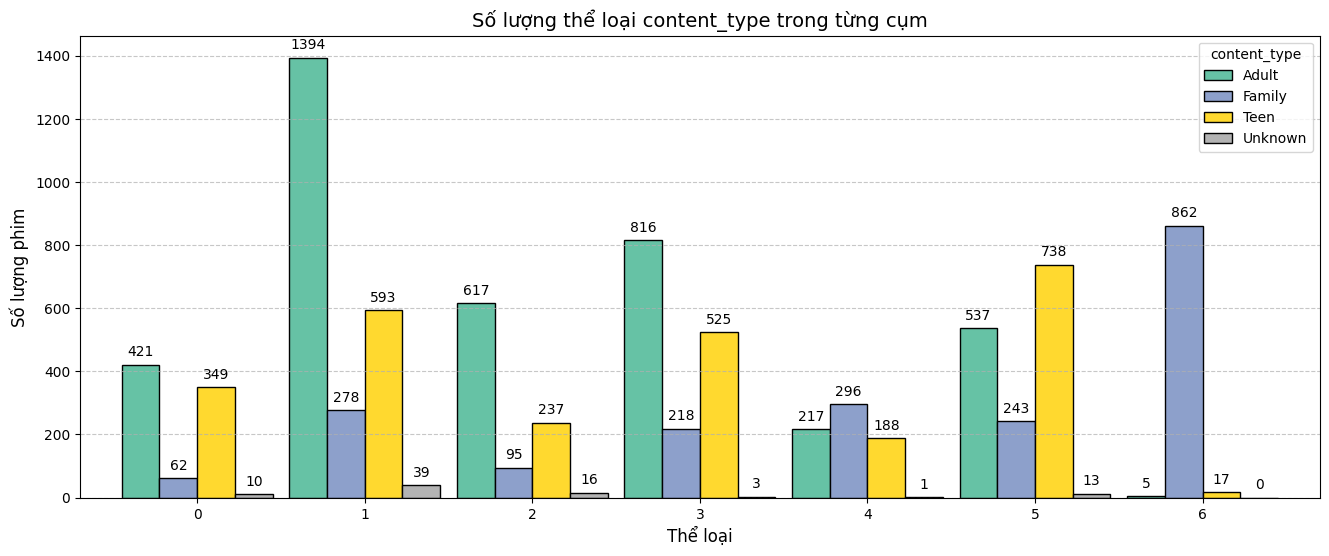

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_content_type_counts = df.groupby(["kmeans_cluster", "content_type"])["show_id"].nunique().unstack(fill_value=0)

plt.figure(figsize=(12, 6))

ax = cluster_content_type_counts.plot(kind="bar", stacked=False, figsize=(16, 6),
                                      colormap='Set2', edgecolor='black', width=0.9)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, 4),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.title("Số lượng thể loại content_type trong từng cụm", fontsize=14)
plt.xlabel("Thể loại", fontsize=12)
plt.ylabel("Số lượng phim", fontsize=12)
plt.xticks(rotation=0)
plt.gca().set_xticklabels([int(label) for label in plt.gca().get_xticks()])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Tổng hợp 5 hình đầu vào để so sánh

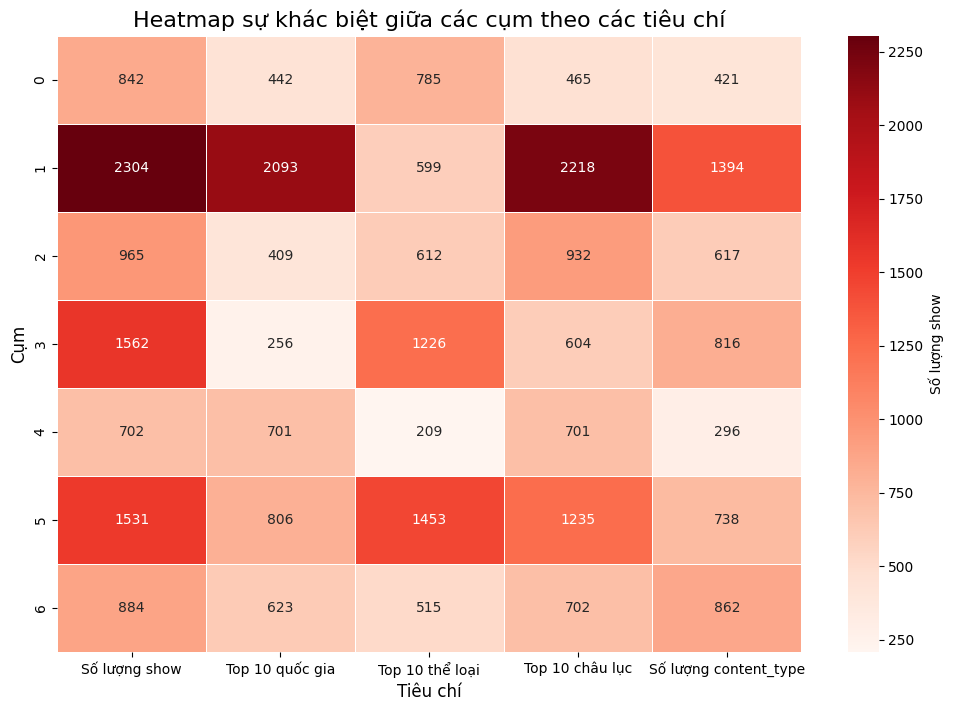

In [41]:
cluster_counts = df.groupby("kmeans_cluster")["show_id"].nunique()

top_10_countries_per_cluster = df.groupby(["kmeans_cluster", "country"])["show_id"].nunique().unstack(fill_value=0)

top_10_genres_per_cluster = df.groupby(["kmeans_cluster", "listed_in"])["show_id"].nunique().unstack(fill_value=0)

top_10_regions_per_cluster = df.groupby(["kmeans_cluster", "region"])["show_id"].nunique().unstack(fill_value=0)

cluster_content_type_counts = df.groupby(["kmeans_cluster", "content_type"])["show_id"].nunique().unstack(fill_value=0)

heatmap_data = pd.DataFrame({
    "Số lượng show": cluster_counts,
    "Top 10 quốc gia": top_10_countries_per_cluster.max(axis=1),
    "Top 10 thể loại": top_10_genres_per_cluster.max(axis=1),
    "Top 10 châu lục": top_10_regions_per_cluster.max(axis=1),
    "Số lượng content_type": cluster_content_type_counts.max(axis=1)
})

heatmap_data = heatmap_data.fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="g", cmap="Reds", linewidths=0.5, cbar_kws={'label': 'Số lượng show'})
plt.title("Heatmap sự khác biệt giữa các cụm theo các tiêu chí", fontsize=16)
plt.xlabel("Tiêu chí", fontsize=12)
plt.ylabel("Cụm", fontsize=12)
plt.show()


In [42]:
def kmeans_worldcloud(cluster_num, axes):
    comment_words = ''
    stopwords = set(STOPWORDS)

    for val in df[df['kmeans_cluster'] == cluster_num].description.drop_duplicates():
        val = str(val)
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens) + " "

    wordcloud = WordCloud(width=700, height=700,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(comment_words)

    axes.imshow(wordcloud, interpolation='bilinear')
    axes.axis("off")
    axes.set_title(f"Word Cloud - Cụm {cluster_num}")

def kmeans_bar_chart(cluster_num, axes):
    top_10_genres_per_cluster = df.groupby(["kmeans_cluster", "listed_in"])["show_id"].nunique().unstack(fill_value=0)
    top_10_genres_cluster = top_10_genres_per_cluster.loc[cluster_num].nlargest(10)
    ax = top_10_genres_cluster.sort_values().plot(kind="barh", color="orange", edgecolor="black", ax=axes)

    for p in ax.patches:
        ax.annotate(f'{p.get_width()}',
                    (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2.),
                    xytext=(2, 0),
                    textcoords="offset points",
                    ha='left', va='center', fontsize=10)

    axes.set_xlabel('Tần suất')
    axes.set_ylabel('Thể loại')
    axes.set_title(f'Top 10 thể loại xuất hiện nhiều nhất trong Cụm {cluster_num}')


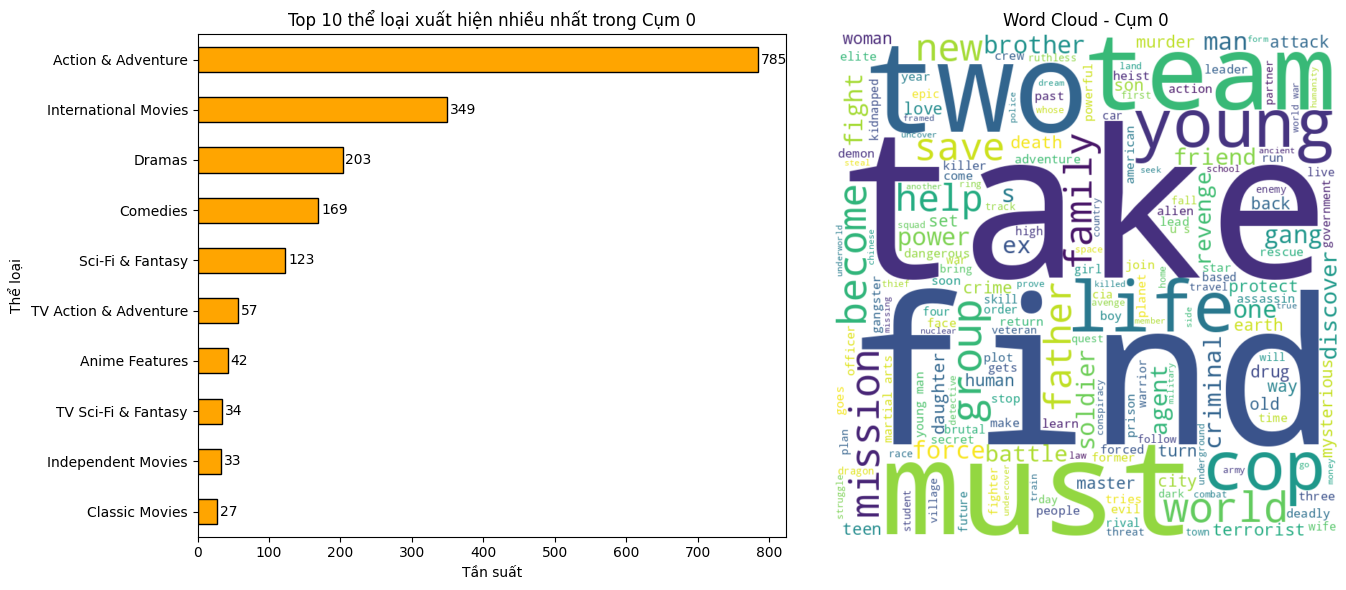

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

kmeans_bar_chart(0, axes[0])
kmeans_worldcloud(0, axes[1])

plt.tight_layout()
plt.show()

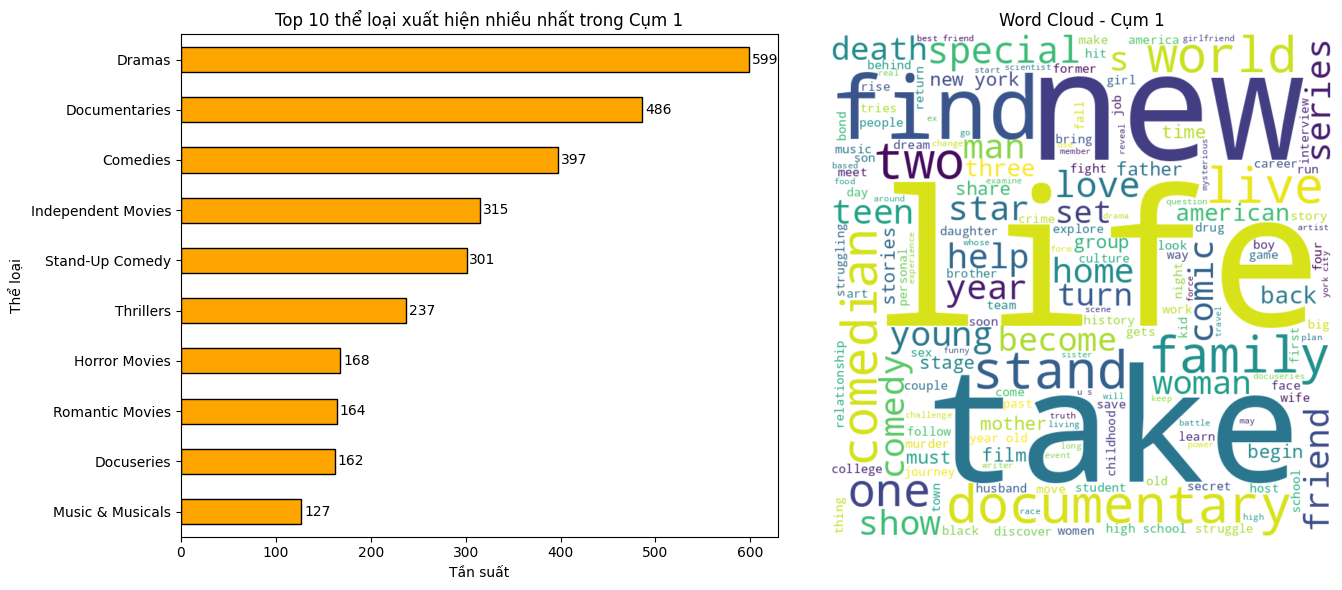

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

kmeans_bar_chart(1, axes[0])
kmeans_worldcloud(1, axes[1])

plt.tight_layout()
plt.show()


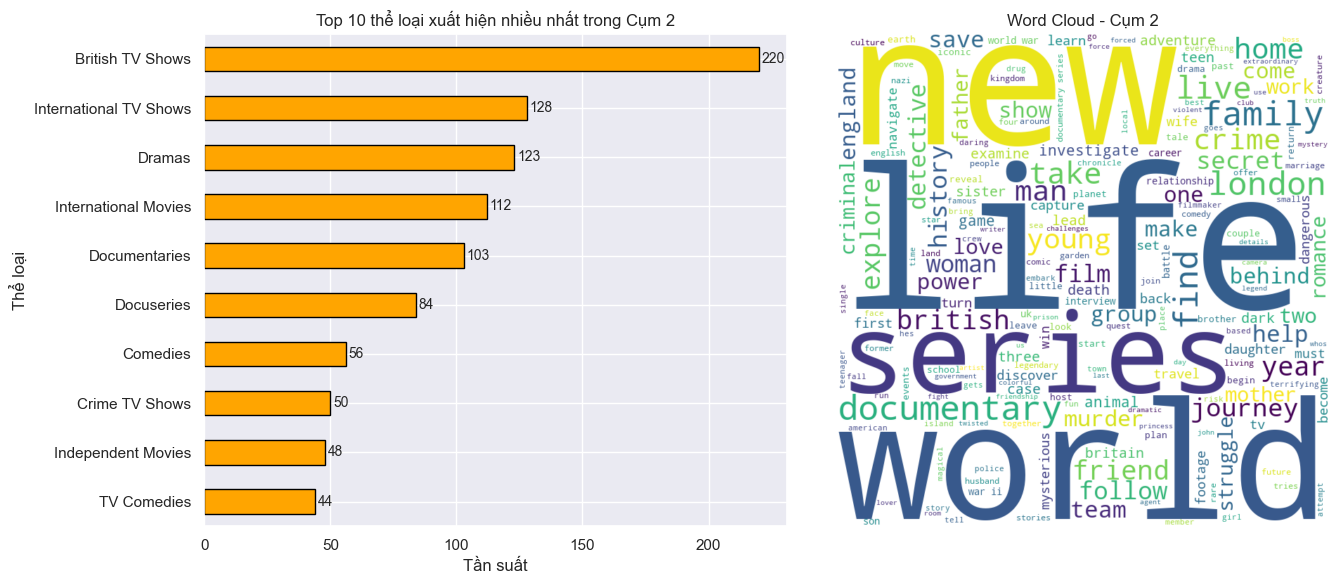

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

kmeans_bar_chart(2, axes[0])
kmeans_worldcloud(2, axes[1])

plt.tight_layout()
plt.show()


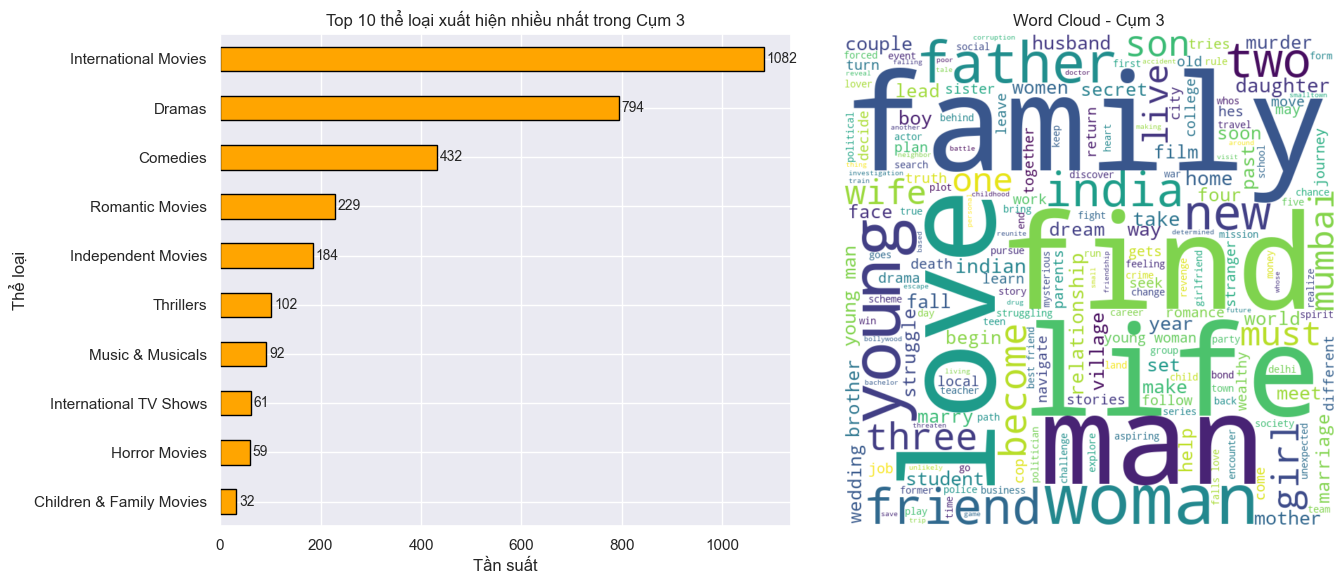

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

kmeans_bar_chart(3, axes[0])
kmeans_worldcloud(3, axes[1])

plt.tight_layout()
plt.show()


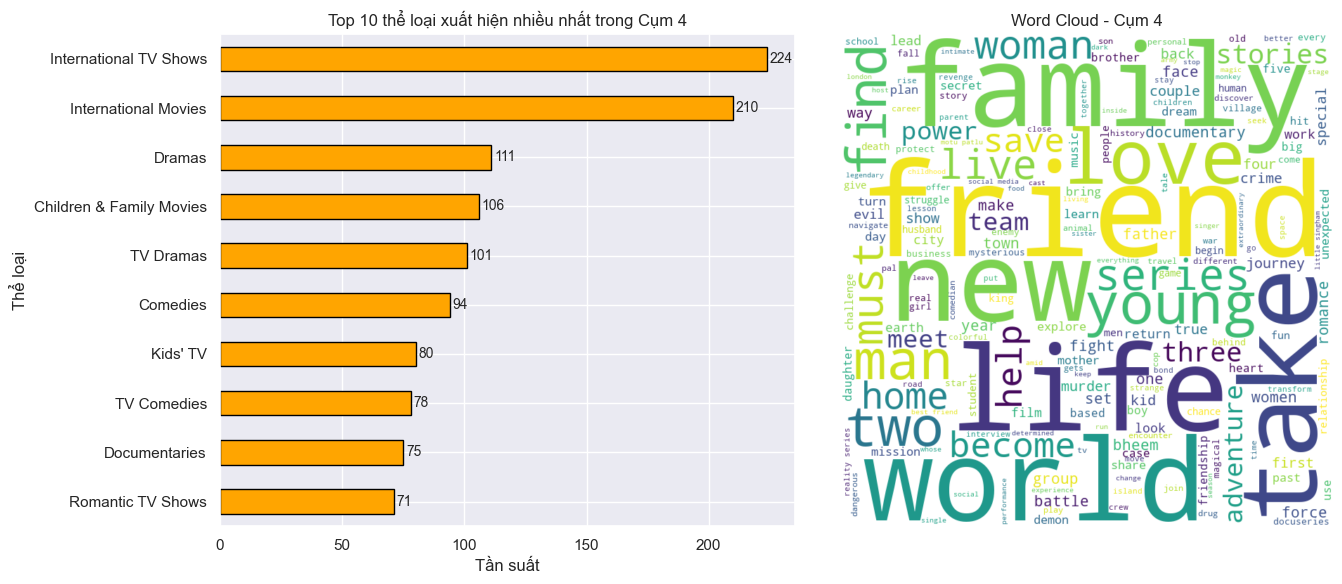

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
kmeans_bar_chart(4, axes[0])
kmeans_worldcloud(4, axes[1])

plt.tight_layout()
plt.show()


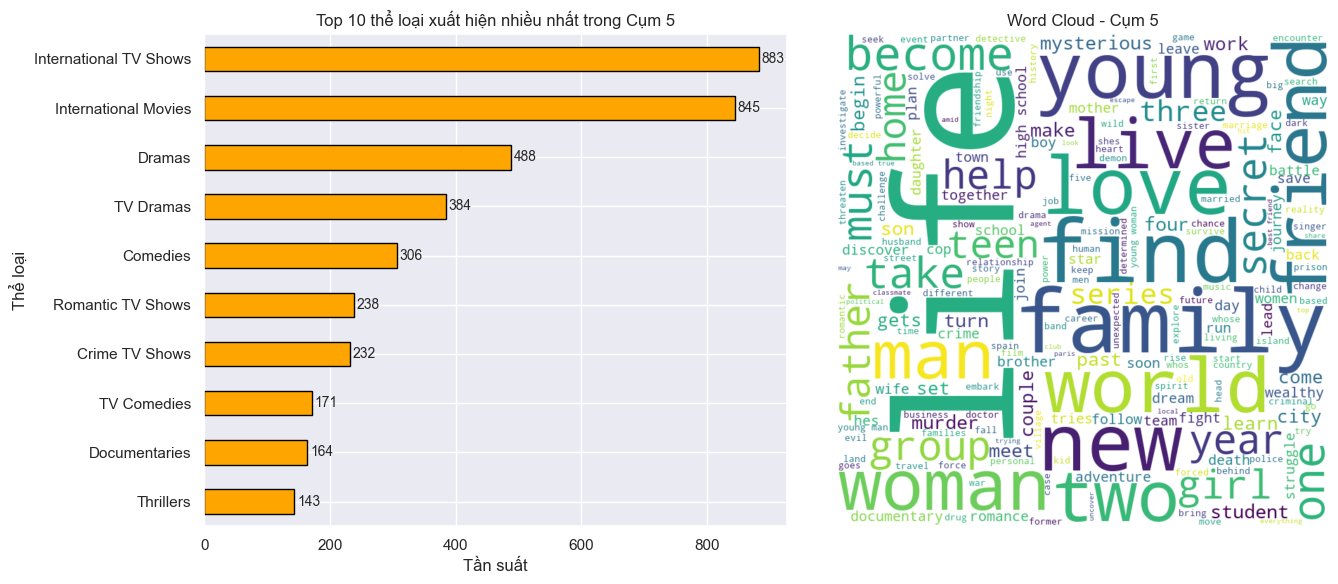

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

kmeans_bar_chart(5, axes[0])
kmeans_worldcloud(5, axes[1])

plt.tight_layout()
plt.show()


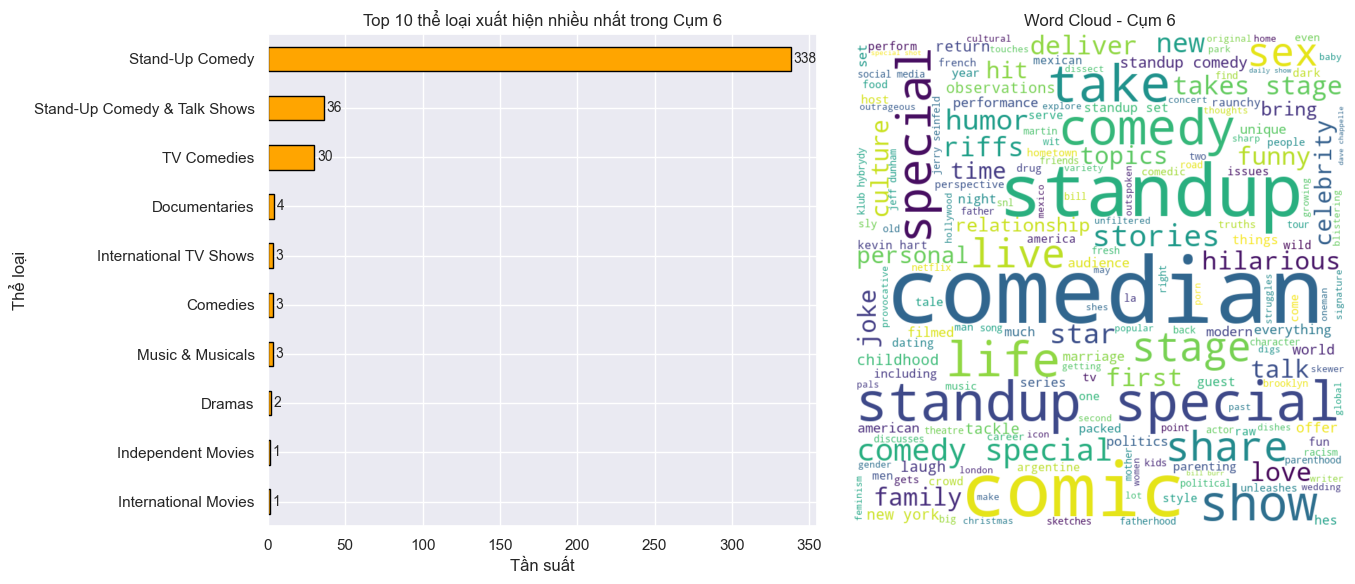

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

kmeans_bar_chart(6, axes[0])
kmeans_worldcloud(6, axes[1])

plt.tight_layout()
plt.show()


# **RECOMMEND SYSTEM**

In [45]:
df = pd.read_csv("/content/gdrive/MyDrive/DaVi/netflix.csv")

In [46]:
recommender_df = df1.copy()

In [47]:
recommender_df['show_id'] = recommender_df.index

In [48]:
def convert(lst):
  return ' '.join(lst)

recommender_df['clustering_attributes'] = recommender_df['clustering_attributes'].apply(lambda x: convert(x))

In [49]:
converted_matrix = x_pca

In [52]:
cosine_sim = cosine_similarity(converted_matrix, converted_matrix)

In [53]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def recommend_10(title, cosine_sim = cosine_sim):
    try:
        title_clean = title.strip().lower()
        recommender_df['title_clean'] = recommender_df['title'].str.strip().str.lower()
        if title_clean not in recommender_df['title_clean'].values:
            return f"Show '{title}' không có trong danh sách."
        idx = recommender_df.loc[recommender_df['title_clean'] == title_clean].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top10 = [i[0] for i in sim_scores[1:11]]
        recommend_content = df[['title', 'listed_in', 'description']].iloc[top10].reset_index(drop=True)
        recommend_df = pd.DataFrame(recommend_content)
        print(f"Các bộ phim tương tự '{title}', bạn có thể thích:")
        return recommend_df
    except Exception as e:
        return f"Error: {str(e)}"

In [54]:
recommend_10('Dick Johnson Is Dead')

Các bộ phim tương tự 'Dick Johnson Is Dead', bạn có thể thích:


title  \
0                                 End Game   
1              Monster High: Freaky Fusion   
2  The Death and Life of Marsha P. Johnson   
3                 Love You... Love You Not   
4      ReMastered: Devil at the Crossroads   
5                             A Family Man   
6                        For Colored Girls   
7                Secrets in the Hot Spring   
8                                 Kazoops!   
9             Black & Privileged: Volume 1   

                                         listed_in  \
0                                    Documentaries   
1                         Children & Family Movies   
2                      Documentaries, LGBTQ Movies   
3  Comedies, International Movies, Romantic Movies   
4                  Documentaries, Music & Musicals   
5                                           Dramas   
6                                           Dramas   
7    Comedies, Horror Movies, International Movies   
8                                         Kids' TV   
9                                           Dramas   

                                         description  
0  Facing an inevitable outcome, terminally ill p...  
1  When Frankie Stein travels back in time, a tee...  
2  As she fights the tide of violence against tra...  
3  A love triangle gets complicated when a female...  
4  Cloaked in mystery, bluesman Robert Johnson le...  
5  A ruthless corporate headhunter battles his ri...  
6  This adaptation of Ntozake Shange's play consi...  
7  When three teen outcasts arrive at a hot sprin...  
8  Music meets imagination in this inventive anim...  
9  When low-income families move into a thriving ...

In [55]:
recommend_10('Peaky Blinders')

Các bộ phim tương tự 'Peaky Blinders', bạn có thể thích:


title                                          listed_in  \
0  The Devil Inside                           Horror Movies, Thrillers   
1   Criminal: Spain  British TV Shows, Crime TV Shows, Internationa...   
2     Little Sister               Comedies, Dramas, Independent Movies   
3      Criminal: UK  British TV Shows, Crime TV Shows, Internationa...   
4           La Niña  Crime TV Shows, International TV Shows, Spanis...   
5        DEATH NOTE  Anime Series, Crime TV Shows, International TV...   
6      Jimi Hendrix                    Documentaries, Music & Musicals   
7     Kiss Me First  British TV Shows, Crime TV Shows, Internationa...   
8   Behind Her Eyes  British TV Shows, International TV Shows, TV D...   
9          Marcella  British TV Shows, Crime TV Shows, Internationa...   

                                         description  
0  At once spooky and grisly, this thriller follo...  
1  Psychological games abound between detectives ...  
2  A former Goth studying to become a nun finds h...  
3  Within the walls of an interrogation room and ...  
4  A former Colombian guerrilla fighter faces cha...  
5  When a Japanese high schooler comes into posse...  
6  Jimi Hendrix's family, friends, and fellow mus...  
7  A lonely young woman hooked on a virtual reali...  
8  A single mother enters a world of twisted mind...  
9  Her marriage just ended and she's returning to...

In [56]:
recommend_10('bbb')

"Show 'bbb' không có trong danh sách."